# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 50

**Author 1 (sciper):** Hana Catic (370754)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   

**Release date:** 22.03.2024  
**Due date:** 19.04.2024 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project that ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like OpenCV and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

TAs should be able to rerun your code end to end without having any issues. If not, you might lose part of the points during grading.

[iapr]: https://github.com/LTS5/iapr

In [1]:
!pip install wget
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install scikit-learn
!pip install python-mnist
!pip install opencv-python

In [8]:
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)
# Other global libraries
import matplotlib.pyplot as plt
import matplotlib
import skimage
import numpy as np
import wget
import os
from typing import Callable

---
# Introduction

In this lab, we will work with the famous MNIST dataset. It is composed of thousands of images (size 28x28) that depict handwritten digits from 0 to 9. The code below will automatically download the data from the online repo (http://yann.lecun.com/exdb/mnist/). This lab aims to create discriminant features from handwritten digits using various approaches. 


Take a look at the data to get a better idea of what you will be working within this lab.

In [9]:
# Create a local folder
folder_lab = os.path.join("..", "data", "data_lab_02")
os.makedirs(folder_lab, exist_ok=True)
# Data url
url_img = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
url_label = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"

# Data filename 
file_img = os.path.join(folder_lab, "train-images-idx3-ubyte.gz")
file_label = os.path.join(folder_lab, "train-labels-idx1-ubyte.gz")

# Download data 
if not os.path.exists(file_img):
    file_img = wget.download(url_img, out=file_img)
    file_label = wget.download(url_label, out=file_label)

print("Data downloaded under folder: {}".format(folder_lab))

Data downloaded under folder: ..\data\data_lab_02


In [10]:
from mnist import MNIST

# Load data
mndata = MNIST(folder_lab, gz=True)
images, labels = mndata.load_training()

# Convert as numpy arrays and binarize images
images = np.array(images).reshape((-1, 28, 28))
labels = np.array(labels)

print("{} Images and {} labels loaded".format(len(images), len(labels)))

60000 Images and 60000 labels loaded


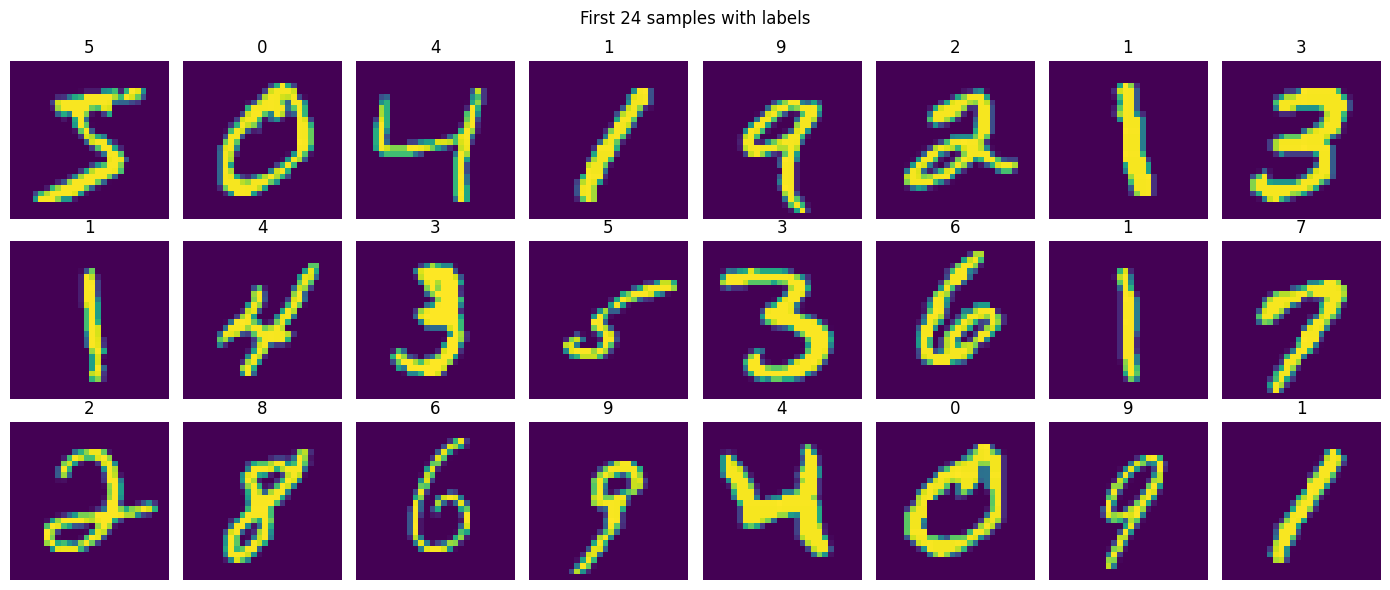

In [11]:
def display_samples(images: np.ndarray, labels:np.ndarray, title: str, cnt: list = None):
    """
    Display images along with labels. 
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images
    labels: np.ndarray (N)
        List of labels associated with the input image
    title: str
        Title of the plot
    cnt: list
        List of contours to display (only used for exercise 1.3 and more)
    """

    # Get the number of images, columns, and rows
    n = len(images)
    n_cols = 8
    r_rows = np.ceil(n/n_cols).astype(int)
    
    # Define plot
    _, axes = plt.subplots(r_rows, n_cols, figsize=(14, 2*r_rows))
    axes = axes.ravel()
    
    
    # Plot all images and labels
    for i in range(n):
        axes[i].imshow(images[i], interpolation="nearest")
        axes[i].axis("off")
        axes[i].set_title(labels[i])
        # Check if need to display contour
        if cnt is not None and len(cnt) == n:
            axes[i].plot(cnt[i][:, 0], cnt[i][:, 1], 'r-*')

    # Set title
    plt.suptitle(title)
    plt.tight_layout()
        
display_samples(images[:24], labels[:24], title="First 24 samples with labels")

---
# Part 1 - Preprocessing


In this lab, we will create different feautre descriptors from digits. However, we will not use all images in the dataset. We will focus on the digits "0" and "4".

## 1.1 Selection (1 pts)

**Q1 (1 pts)** Your first task is to complete the function `extract_label` such that it selects from the input data only the images that are labeled as a given `target_label`. This function will be used to extract 0s and 4s from the data cohort. When running the code, the plots should only show you samples that are 0s (first plot) and 4s (second plot)

In [12]:
def extract_label(images: np.ndarray, labels: np.ndarray, target_label: int):
    """
    The function returns only the images that have target_label as labels.
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images - handwritten digits 
    labels: np.ndarray (N)
        List of labels associated with the input image
    target_label: int
        Selected target label

    Return
    ------
    img_extract: np.ndarray (M, 28, 28)
        Extracted images that have target_label as label (M should be lower than N).
    """

    n, d, _ = np.shape(images) 
    img_extract = np.zeros((30, d, d))
    
    # ------------------

    img_extract = [ images[idx] for idx in range(len(labels)) if labels[idx] == target_label]

    # ------------------
    
    return img_extract

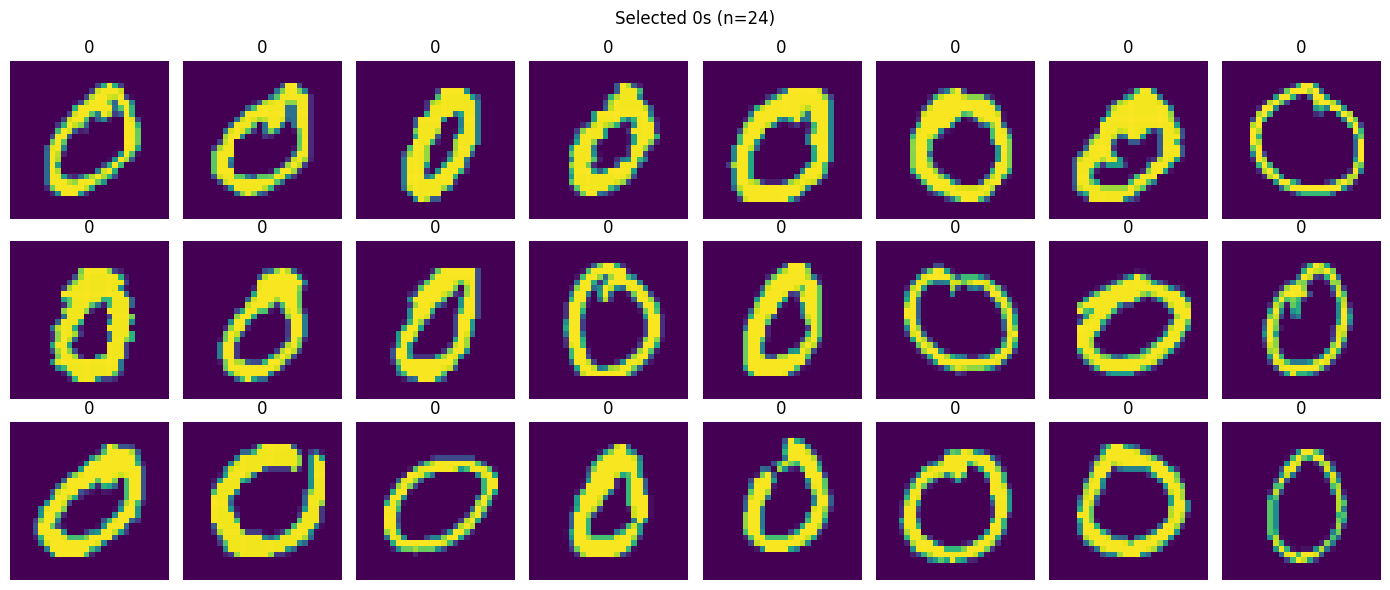

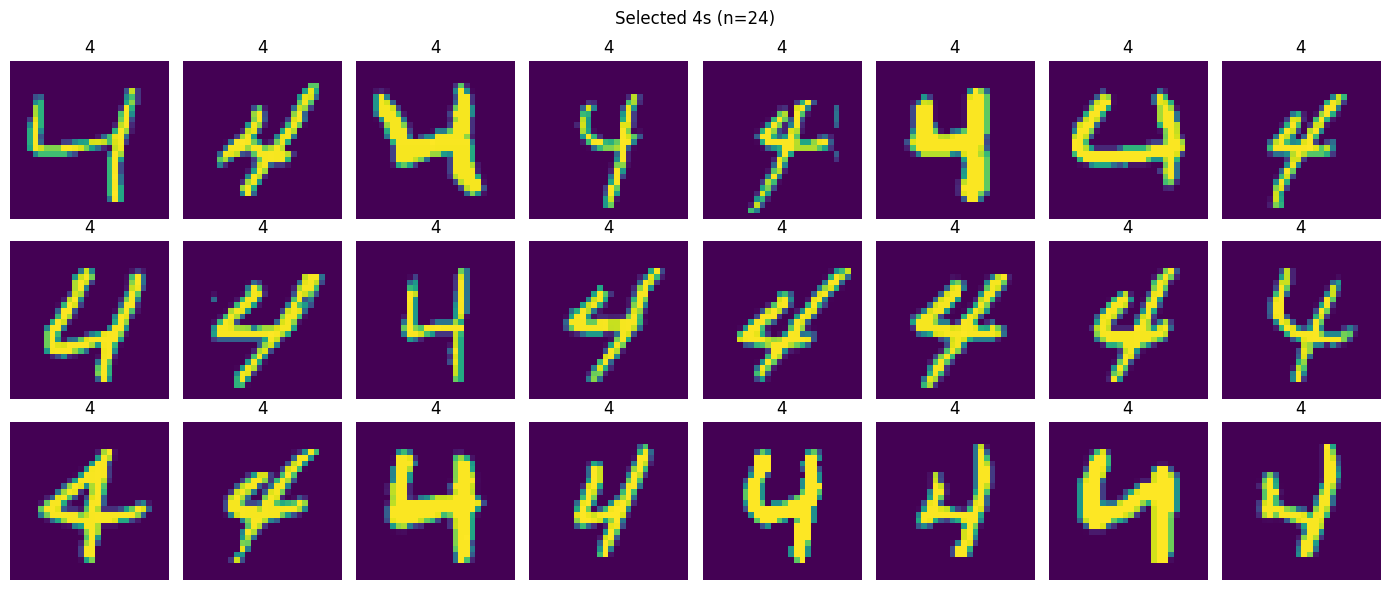

In [13]:
# Set the number of digits to include
n = 1000
# Set the number of digits to display
n_plot=24
n_samples = 11
# Set which digit to consider
label_a = 0
label_b = 4

# Filter images
images_a = extract_label(images, labels=labels, target_label=label_a)[:n]
images_b = extract_label(images, labels=labels, target_label=label_b)[:n]

# Display random results
display_samples(images=images_a[:n_plot], labels=[str(label_a)]*n_plot, title="Selected {}s (n={})".format(label_a, n_plot))
display_samples(images=images_b[:n_plot], labels=[str(label_b)]*n_plot, title="Selected {}s (n={})".format(label_b, n_plot))

## 1.2 Preprocessing (1 pts)

Before computing the Fourier descriptors we need to preprocess the images.

* **Q1 (1 pts)**: Complete the function `preprocess` such that it cleans the input images. Take a look at the example images above and try to think what could be improved to allow better uniformity of the data. Take advantage of what you have learned in the previous lab.

In [84]:
import skimage.morphology


def preprocess(images: np.ndarray):
    """
    Apply the processing step to images to achieve better data uniformity.
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images

    Return
    ------
    img_process: np.ndarray (N, 28, 28)
        Processed images.
    """

    # Get the shape of input data and set dummy values
    n, d, _ = np.shape(images) 
    img_process = np.zeros_like(images)
    
    # ------------------
    threshold = 70
    img_process = [apply_threshold(images[idx], threshold) for idx in range(len(images))]
    img_process = [apply_morphology(img_process[idx], 5, 2) for idx in range(len(images))]
    # ------------------

    return img_process

def apply_threshold(image, threshold):
    
    return image > threshold

def apply_morphology(image, size_objects, size_holes):
    
    img_obj = skimage.morphology.remove_small_objects(image, size_objects, connectivity=1, out=None)
    img_obj = skimage.morphology.remove_small_holes(img_obj, size_holes, connectivity=1,out=None)
    
    return img_obj


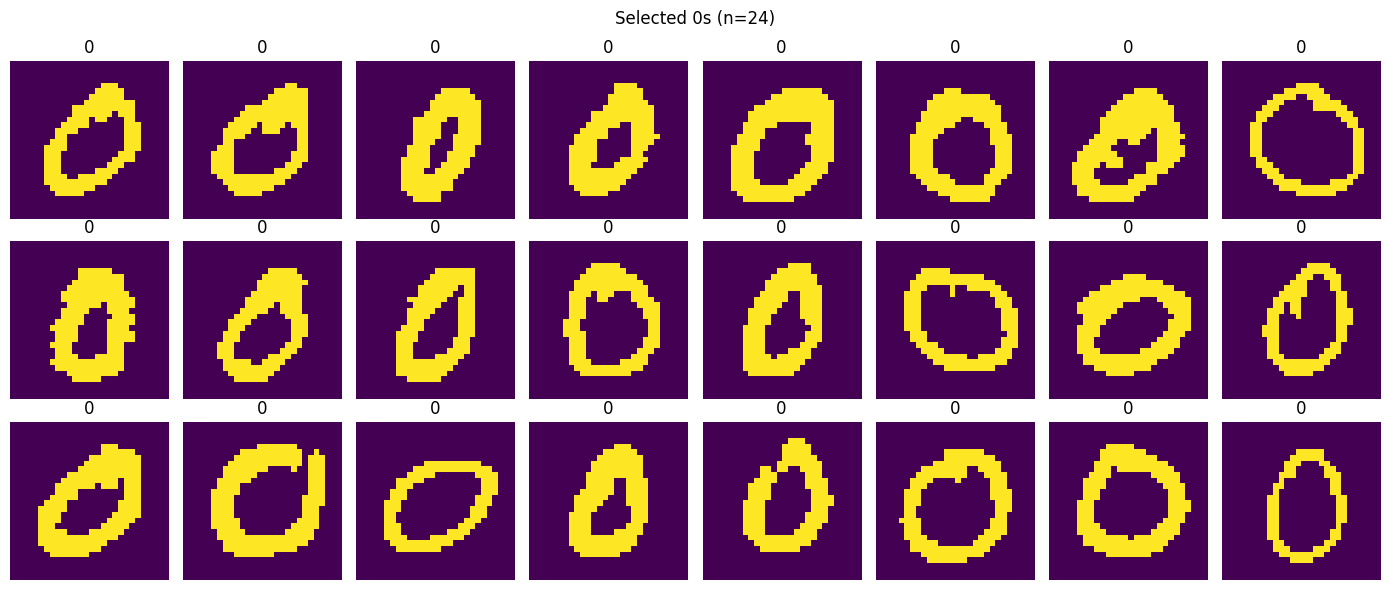

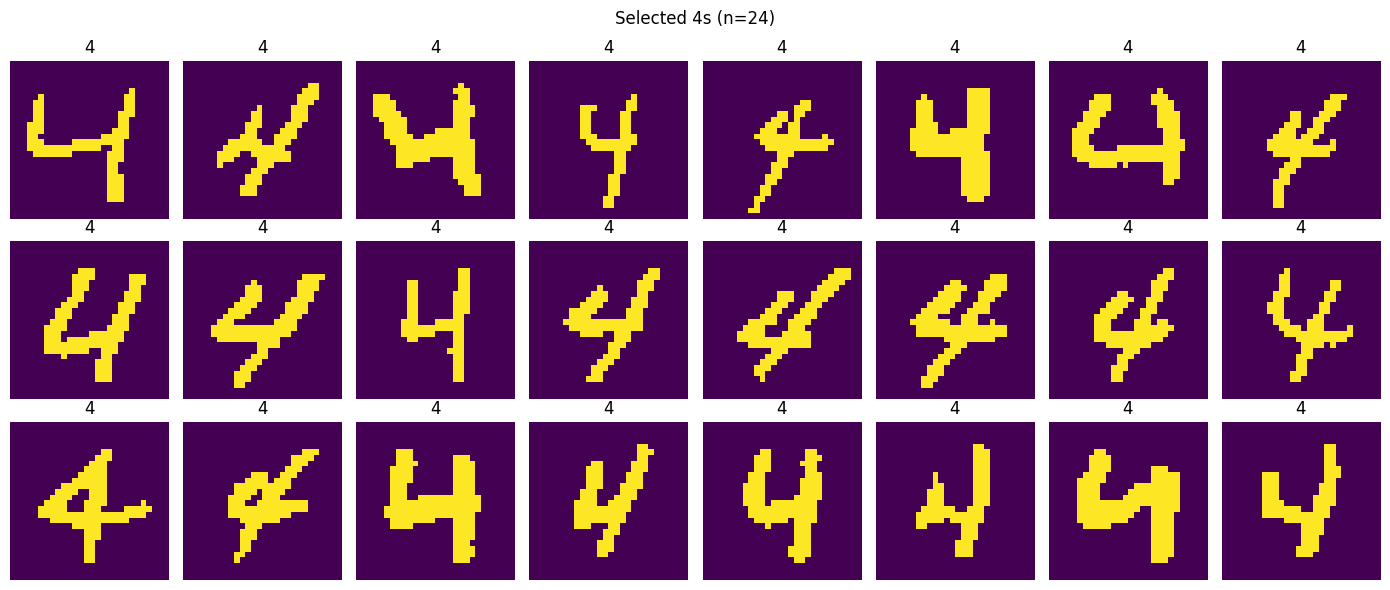

In [85]:
# Extract images with 0s ans 4s
images_p_a = preprocess(images=images_a)
images_p_b = preprocess(images=images_b)

# Display results
display_samples(images=images_p_a[:n_plot], labels=[label_a]*n_plot, title="Selected {}s (n={})".format(label_a, n_plot))
display_samples(images=images_p_b[:n_plot], labels=[label_b]*n_plot, title="Selected {}s (n={})".format(label_b, n_plot))

---
# Part 2 - Fourier Descriptors


## 2.1. Get contour and descriptors (9 pts)

In this section, we will create Fourier descriptors from digits. The next step in our pipeline will be to detect the contours. To do so you can use existing algorithm available online such as `find_contours`([doc](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours)) from skcit-image or `findContours` ([doc](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)) from opencv. 

* **Q1 (2 pts)**: Complete the function `find_contour` below such that it returns the contour estimations of the given images. The provided `display_samples` function will display the returned contours for a subset of images.

In [ ]:
def find_contour(images: np.ndarray):
    """
    Find the contours for the set of images
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images to process

    Return
    ------
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    """

    # Get number of images to process
    N, _, _ = np.shape(images)
    # Fill in dummy values (fake points)
    contours = [np.array([[0, 0], [1, 1]]) for i in range(N)]

    # ------------------
    # Your code here ... 
    # ------------------
    
    return contours
    

In [ ]:
# Get contours
cnt_p_a = find_contour(images_p_a)
cnt_p_b = find_contour(images_p_b)

# Define plot titles
title_a = "Preprocessed {}s w/ contours (n={})".format(label_a, n_plot)
title_b = "Preprocessed {}s w/ contours (n={})".format(label_b, n_plot)

# Display results
display_samples(
    images=images_p_a[:n_plot], labels=[label_a]*n_plot, cnt=cnt_p_a[:n_plot], title=title_a)
display_samples(
    images=images_p_b[:n_plot], labels=[label_b]*n_plot, cnt=cnt_p_b[:n_plot], title=title_b)


Now that we are able to properly detect shape contours, we can finally compute Fourier descriptors. However, we still face a small issue. The allow a fair comparison between the Fourier descriptors we need to ensure that all descriptors have the same length.

* **Q2 (2 pts)**: Implement the function `compute_descriptor_padding` that takes as input the computed contours from before and returns the Fourier descriptors for each contour. Use `fft` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)) from Numpy to compute the transformation. Use the `n_sample` argument to set the number of points to consider per contour. If the contour is longer than `n_sample` discard the extra points. If the contour is shorter than `n_sample`, use 0 paddings. Make sure that the first element of the descriptor represent the continuous component in the frequency domain.

In [ ]:
def compute_descriptor_padding(contours: np.ndarray, n_samples: int = 11):
    """
    Compute Fourier descriptors of input images
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider. If the contour length is higher, discard the remaining part. If it is shorter, add padding.
        Make sure that the first element of the descriptor represents the continuous component.

    Return
    ------
    descriptors: np.ndarray complex (N, n_samples)
        Computed complex Fourier descriptors for the given input images
    """

    N = len(contours)
    # Look for the number of contours
    descriptors = np.zeros((N, n_samples), dtype=np.complex_)

    # ------------------
    # Your code here ... 
    # ------------------

    return descriptors


The code below uses the `plot_features` function to display the computed Fourier descriptors. We display the real, imaginary, and absolute components, respectively. Each color depicts a different digit. We use 2D plots to highlight the clustering capability of the components.
* **Q3 (1 pts)**: Comment on the quality of the Fourier descriptors. Do you think they are good feature descriptors? (justify)
    * **Answer**: ...
* **Q4 (1 pts)**: Knowing that we used `n_samples=11` to compute the Fourier transform, what do the components 0, 1, 5, and 10 represent as frequencies? (high, medium, constant, etc.)
    * **Answer**: ...

In [ ]:
def plot_features(features_a: np.ndarray, features_b: np.ndarray, label_a: str, label_b: str, title: str):
    """
    Plot feature components a and b.
    
    Args
    ----
    features_a: np.ndarray (N, D)
        Feature a with N samples and D complex features. 
    features_b: np.ndarray (N, D)
        Feature b with N samples and D complex features.
    label_a: str
        Name of the feature a.
    label_b: str
        Name of the feature b.
    """

    # Number of paris to display
    n_features = features_a.shape[1]
    # Define pairs for 2D plots
    pairs = np.array(range(2*np.ceil(n_features / 2).astype(int)))
    # Check if odd lenght, shift second feature to have pairs
    if n_features % 2 == 1:
        pairs[2:] = pairs[1:-1]
    # Convert to 2d array
    pairs = pairs.reshape(-1, 2)

    # Plot each pairs and labels
    n_plots = len(pairs)
    _, axes = plt.subplots(3, n_plots, figsize=(15, 8))
    
    for i, (pa, pb) in enumerate(pairs):
        # Real
        axes[0, i].scatter(np.real(features_a[:, pa]), np.real(features_a[:, pb]), label=label_a, s=10, alpha=0.1)
        axes[0, i].scatter(np.real(features_b[:, pa]), np.real(features_b[:, pb]), label=label_b, s=10, alpha=0.1)
        axes[0, i].set_xlabel("Component {}".format(pa))
        axes[0, i].set_ylabel("Component {}".format(pb))
        axes[0, i].set_title("Real {} vs {}".format(pa, pb))
        axes[0, i].legend()
        # Imag
        axes[1, i].scatter(np.imag(features_a[:, pa]), np.imag(features_a[:, pb]), label=label_a, s=10, alpha=0.1)
        axes[1, i].scatter(np.imag(features_b[:, pa]), np.imag(features_b[:, pb]), label=label_b, s=10, alpha=0.1)
        axes[1, i].set_xlabel("Component {}".format(pa))
        axes[1, i].set_ylabel("Component {}".format(pb))
        axes[1, i].set_title("Imag. {} vs {}".format(pa, pb))
        axes[1, i].legend()
        # Abs
        axes[2, i].scatter(np.abs(features_a[:, pa]), np.abs(features_a[:, pb]), label=label_a, s=10, alpha=0.1)
        axes[2, i].scatter(np.abs(features_b[:, pa]), np.abs(features_b[:, pb]), label=label_b, s=10, alpha=0.1)
        axes[2, i].set_xlabel("Component {}".format(pa))
        axes[2, i].set_ylabel("Component {}".format(pb))
        axes[2, i].set_title("Abs. {} vs {}".format(pa, pb))
        axes[2, i].legend()

    plt.suptitle(title)
    plt.tight_layout()

In [ ]:
# Compute the descriptors based on the contours
feat_a = compute_descriptor_padding(contours=cnt_p_a, n_samples=n_samples)
feat_b = compute_descriptor_padding(contours=cnt_p_b, n_samples=n_samples)

# Plot components
plot_features(
    features_a=feat_a,
    features_b=feat_b,
    label_a=label_a, label_b=label_b,
    title="Real/Imag./Absolute features",
)

As you might have realized before, the computed Fourier descriptors do not help us to find an optimal separation between the digits. This mainly comes from the fact that using 0 padding is a cheap and inefficient way to ensure homogeneity in length for descriptors. A better solution would be to ensure that we have the same number of points along the contour for each digit. To do so, we need to implement a new function that will resample the contour such that we always have the same number of points no matter the shape.

* **Q5 (2 pts)**: Implement the function `linear_interpolation` that takes as input the contours with various lengths and the wanted number of samples per contour for resampling. For each contour, resample the points such that each contour has the same length `n_samples`. We want the points to be uniformly distributed (same distance between points) along the contour. You can use for example the function `interp` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.interp.html)) from Numpy to perform the interpolation. The function `display_samples` will display the contour for different lengths.

In [ ]:
def linear_interpolation(contours: np.ndarray, n_samples: int = 11):
    """
    Perform interpolation/resampling of the contour across n_samples.
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider along the contour.

    Return
    ------
    contours_inter: np.ndarray complex (N, n_samples, 2)
        Interpolated contour with n_samples
    """

    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))
    
    # ------------------
    # Your code here ... 
    # ------------------
        
    return contours_inter


In [ ]:
# Get a different number of samples for the contour of the shapes
n_samples_test = [2, 5, 10, 15, 20, 40, 60, 80]

# Resample contours
cs = []
for i, n in enumerate(n_samples_test):
    c = linear_interpolation(cnt_p_a, n_samples=n)
    cs.append(c[0])

# Display results with overlay
display_samples(
    images=np.repeat(images_p_a[0][None], repeats=8, axis=0), 
    labels=["n={}".format(n) for n in n_samples_test], 
    cnt=cs, 
    title="Contour interpolation w/ different values"
)

Now that we have implemented our resampling approach we can revisualize the clustering efficiency of our descriptors.

* **Q6 (1 pts)**: Comment on the quality of the descriptors. Is it better than before? is there a frequency/component that appears to work better? Does it make sense?
    * **Answer**: ...

In [ ]:
# Compute feature descriptors with resampling
feat_a = compute_descriptor_padding(contours=linear_interpolation(cnt_p_a, n_samples=n_samples), n_samples=n_samples)
feat_b = compute_descriptor_padding(contours=linear_interpolation(cnt_p_b, n_samples=n_samples), n_samples=n_samples)

# Plot components
plot_features(
    features_a=feat_a,
    features_b=feat_b,
    label_a=label_a, label_b=label_b,
    title="Real/Imag./Absolute features (resampling)",
)


## 2.2. Reconstruction (2pts)

For this part, we will now try to go the other way. Given a Fourier descriptor we will try to retrieve the original shape. 
* **Q1 (1 pts)** Implement the function `compute_reverse_descriptor` that takes as input a single descriptor and reverses it to x and y coordinates given a number of samples `n_samples`. Use the function `ifft` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html)) from Numpy.

In [ ]:
def compute_reverse_descriptor(descriptor: np.ndarray, n_samples: int = 11):
    """
    Reverse a Fourier descriptor to xy coordinates given a number of samples.
    
    Args
    ----
    descriptor: np.ndarray (D,)
        Complex descriptor of length D.
    n_samples: int
        Number of samples to consider to reverse transformation.

    Return
    ------
    x: np.ndarray complex (n_samples,)
        x coordinates of the contour
    y: np.ndarray complex (n_samples,)
        y coordinates of the contour
    """

    x = np.zeros(n_samples)
    y = np.zeros(n_samples)
    
    # ------------------
    # Your code here ... 
    # ------------------

    return x, y


With the function `plot_reconstruction` we plot an example of the reconstruction of the digits. We display the result as we progressively add more frequencies. We start with the first component (component 0) and then add frequency pairs from low to high frequencies.

* **Q2 (1 pts)**: Based on your observation, do you think 11 samples are enough to properly describe the digits below? (justify)

In [ ]:
def plot_reconstruction(image, descriptor):
    """
    Plot Fourier descriptors reconstruction.
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
    descriptor: np.ndarray (D, )
        Complex descriptor with D features
    """
    # Get number of samples
    n_samples = len(descriptor)
    n_mid = n_samples // 2
    # Get intervals
    n_rec = np.linspace(0, n_mid, n_mid+1).astype(int)

    # Plot reconstruction
    _, axes = plt.subplots(1, len(n_rec), figsize=(16, 5))
    
    for i, n in enumerate(n_rec):
        # Create a local copy of the descriptor
        d = descriptor.copy()
        # Remove high frequencies (set to 0)
        d = np.fft.fftshift(d)
        d[:n_mid-n] = 0
        d[n_mid+1+n:] = 0
        # Reverse descriptors to coordinates
        x, y = compute_reverse_descriptor(descriptor=np.fft.ifftshift(d), n_samples=n_samples)
        # Plot contour with image overlay
        axes[i].imshow(image, interpolation='nearest')
        axes[i].scatter(x, y)
        axes[i].plot(x, y)
        axes[i].axis('off')
        axes[i].set_title("N frequencies = {}".format(1 + 2*n))

    plt.tight_layout()

# Plot reconstruction
plot_reconstruction(image=images_p_a[0], descriptor=feat_a[0, :])
plot_reconstruction(image=images_p_b[0], descriptor=feat_b[0, :])

## 2.3. Invariance (6 pts)

For the last part with Fourier descriptors, we will check for descriptors invariance. As seen in class, if handled properly Fourier descriptors can be invariant to translation, rotation, and scaling.

* **Q1 (3 pts)**: Implement the functions `apply_rotation`, `apply_scaling`, and `apply_translate` to apply random rotation, scaling, and translation to input images. For scaling and translation, we recommend avoiding large values where the digits are cropped (out of frame). You can use the `random` package ([doc](https://numpy.org/doc/1.16/reference/routines.random.html)) from Numpy to generate random values.

In [ ]:
def apply_rotation(img: np.ndarray):
    """
    Apply random rotation to input the image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    rotated: np.ndarray (28, 28)
        Rotated source images
    """

    rotated = np.zeros_like(img)
    
    # ------------------
    # Your code here ... 
    # ------------------
    
    return rotated


def apply_scaling(img: np.ndarray):
    """
    Apply random scaling to input image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    scaled: np.ndarray (28, 28)
        Scaled source images
    """
    
    scaled = np.zeros_like(img)
    
    # ------------------
    # Your code here ... 
    # ------------------
    
    return scaled

def apply_translate(img: np.ndarray):
    """
    Apply random x and y translation to input image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    translated: np.ndarray (28, 28)
        Translated source images
    """
    
    translated = np.zeros_like(img)
    
    # ------------------
    # Your code here ... 
    # ------------------
    
    return translated


In [ ]:
def apply_tranformation(imgs: np.ndarray, func: Callable):
    """
    Apply random transformation to a set of images

    Args
    ----
    image: np.ndarray (N, 28, 28)
        Source images
    func: Callable
        Transformation function to apply to input images
        
    Return
    ------
    imgs_trans: np.ndarray (N, 28, 28)
        Transformed images
    """

    # Get the number of images
    n = len(imgs)
    imgs_trans = np.zeros_like(imgs)

    # Apply transformation
    for i in range(n):
        imgs_trans[i] = func(imgs[i])

    return imgs_trans
        

def plot_transform(img, function, title):
    """
    Plot random transformation for visualization purposes

    Args
    ----
    image: np.ndarray (28, 28)
        Source image
    func: Callable
        Transformation function to apply to input images
    title: str
        Title of the plot
    """
    
    # Fix the number of examples to display 
    n = 10
    _, axes = plt.subplots(1, n, figsize=(16, 2))

    # Apply n random transformation on input images
    for i in range(n):
        trans = function(img=img)
        axes[i].imshow(trans, interpolation='nearest')
        axes[i].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    

In [ ]:
# Display random rotations
plot_transform(img=images_p_a[0], function=apply_rotation, title="Apply different rotation on image")

In [ ]:
# Display random scaling
plot_transform(img=images_p_a[0], function=apply_scaling, title="Apply different scaling on image")

In [ ]:
# Display random translations
plot_transform(img=images_p_a[0], function=apply_translate, title="Apply different translation on image")

Now that we implemented our transformation, we can test for feature invariance. To assess the robustness of the Fourier descriptors to image transformations, we compute the error between the original descriptors (before transformation) to the one after transformation. 

* **(1 pts)**: Complet the function `translation_invariant` to make the Fourier deciptor invariant to translation. Does the error decrease after treatment for translation invariance? Is it null, if not why?
    * **Answer**: ...

In [ ]:
def translation_invariant(features):
    """
    Make input Fourier descriptors invariant to translation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to translation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    # Your code here ... 
    # ------------------
    
    return features_inv

In [ ]:
# Get descriptors for translated images
cnt_t_a = find_contour(apply_tranformation(imgs=images_p_a, func=apply_translate))
feat_t_a = compute_descriptor_padding(contours=linear_interpolation(cnt_t_a))

# Get invariant features
a = translation_invariant(feat_a)
b = translation_invariant(feat_t_a)

# Compute errors
error_no_corr = np.abs(feat_a - feat_t_a).mean()
error_corr = np.abs(a - b).mean()
# Print averaged error before
print("Translation error: {:.2f}".format(error_no_corr))
# Print averaged error after
print("Corrected translation error: {:.2f}".format(error_corr))

# plot features distribution
plot_features(
    features_a=feat_a,
    features_b=feat_t_a,
    label_a=label_a, label_b=str(label_a)+"-trans",
    title="Features w/o translation correction (error: {:.2f})".format(error_no_corr),
)

plot_features(
    features_a=a,
    features_b=b,
    label_a=label_a, label_b=str(label_a)+"-trans",
    title="Features w/ translation correction (error: {:.2f})".format(error_corr),
)

* **(1 pts)**: Complet the function `rotation_invariant` to make the Fourier deciptor invariant to rotation. Does the error decrease after treatment for rotation invariance? Do you think that selecting specific rotation angles might help the error to decrease even lower?
    * **Answer**: ...

In [ ]:
def rotation_invariant(features):
    """
    Make input Fourier descriptors invariant to rotation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to rotation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    # Your code here ... 
    # ------------------

    return features_inv

In [ ]:
# Get descriptors for rotation imagescan
cnt_r_a = find_contour(apply_tranformation(imgs=images_p_a, func=apply_rotation))
feat_r_a = compute_descriptor_padding(contours=linear_interpolation(cnt_r_a))

# Get invariant features
a = rotation_invariant(feat_a)
b = rotation_invariant(feat_r_a)

# Compute errors
error_no_corr = np.abs(feat_a - feat_r_a).mean()
error_corr = np.abs(a - b).mean()
# Print averaged error before
print("Rotation error: {:.2f}".format(error_no_corr))
# Print averaged error after
print("Corrected rotation error: {:.2f}".format(error_corr))

# plot features distribution
plot_features(
    features_a=feat_a,
    features_b=feat_r_a,
    label_a=label_a, label_b=str(label_a)+"-rot",
    title="Features w/o rotation correction (error: {:.2f})".format(error_no_corr),
)

plot_features(
    features_a=a,
    features_b=b,
    label_a=label_a, label_b=str(label_a)+"-rot",
    title="Features w/ rotation correction (error: {:.2f})".format(error_corr),
)

* **(1 pts)**: Complet the function `scaling_invariant` to make the Fourier deciptor invariant to scaling. Does the error decrease after treatment for scaling invariance? Is it null? Why?
    * **Answer**: ...

In [ ]:
def scaling_invariant(features):
    """
    Make input Fourier descriptors invariant to scaling.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to scaling of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    # Your code here ... 
    # ------------------

    return features_inv

In [ ]:
# Get descriptors for scaling images
cnt_s_a = find_contour(apply_tranformation(imgs=images_p_a, func=apply_scaling))
feat_s_a = compute_descriptor_padding(contours=linear_interpolation(cnt_s_a))

# Get invariant features
a = scaling_invariant(feat_a)
b = scaling_invariant(feat_s_a)

# Compute errors
error_no_corr = np.abs(feat_a - feat_t_a).mean()
error_corr = np.abs(a - b).mean()
# Print averaged error before
print("Scaling error: {:.2f}".format(error_no_corr))
# Print averaged error after
print("Corrected scaling error: {:.2f}".format(error_corr))

# plot features distribution
plot_features(
    features_a=feat_a,
    features_b=feat_s_a,
    label_a=label_a, label_b=str(label_a)+"-sca",
    title="Features w/o scaling correction (error: {:.2f})".format(error_no_corr),
)

plot_features(
    features_a=a,
    features_b=b,
    label_a=label_a, label_b=str(label_a)+"-sca",
    title="Features w/ scaling correction (error: {:.2f})".format(error_corr),
)

---
# PART 3 - Other descriptors

## 3.1 Distance map (5 pts)

In this part, we will learn how to use a distance map as a feature descriptor. 

* **Q1 (1 pts)**: To compute a distance map we first need a reference pattern. Complete the function `reference_pattern`. The function takes as input a list of images and computes the reference pattern as the average of all shapes.

In [ ]:
def reference_pattern(imgs):
    """
    Compute the reference pattern for a given set of images. The reference pattern 
    is estimated as the average of all images of the same pattern.

    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
        
    Return
    ------
    pattern: np.ndarray (28, 28)
        Thresholded reference pattern that is the average of all shapes.
    """

    # Initialize pattern
    pattern = np.zeros((imgs[0].shape[0], imgs[0].shape[1]))
    
    # ------------------
    # Your code here ... 
    # ------------------
   
    return pattern

In [ ]:
def plot_reference_patterns(
    pattern_a: np.ndarray, pattern_b: np.ndarray, title_a: str, title_b: str, map_a: np.ndarray = None, map_b: np.ndarray = None
):
    """
    Plot the reference patterns for the two patterns as well as distance maps if provided

    Args
    ----
    pattern_a: np.ndarray (28, 28)
        The first pattern to display
    pattern_b: np.ndarray (28, 28)
        The second pattern to display 
    title_a: str
        Title of the first plot
    title_a: str
        Title of the first plot 
    map_a: np.ndarray (28, 28)
        Distance map, If None, the map is not plotted
    map_b: np.ndarray (28, 28)
        Distance map 2nd, If None, the map is not plotted
    """
    
    # Display results
    fig, axes = plt.subplots(1, 4, figsize=(10, 2))
    # Remove axes
    [a.axis("off") for a in axes]
    # Show patterns
    axes[0].imshow(pattern_a, interpolation="nearest")
    axes[0].set_title(title_a)
    axes[1].imshow(pattern_b, interpolation="nearest")
    axes[1].set_title(title_b)
    # Check if distance map exists
    if map_a is not None:
        pcm = axes[2].imshow(map_a, interpolation='nearest')
        axes[2].set_title(title_a + "\n(Dist. map)")
        fig.colorbar(pcm, ax=axes[2])
    if map_a is not None:
        pcm = axes[3].imshow(map_b, interpolation='nearest')
        axes[3].set_title(title_b + " \n(Dist. map)")
        fig.colorbar(pcm, ax=axes[3], label="distance to shape")
    plt.tight_layout()
    
# Compute the pattern for both digits
pattern_a = reference_pattern(images_p_a)
pattern_b = reference_pattern(images_p_b)

plot_reference_patterns(
    pattern_a=pattern_a,
    pattern_b=pattern_b, 
    title_a="Reference pattern {}".format(label_a),
    title_b="Reference pattern {}".format(label_b),
)


* **Q2 (2 pts)**: The next part will be to compute a distance map from the generated pattern. By pre-computing the distance map we can speedup the inference time. Complete the function `compute_distance_map`. We expect the values of the map to represent the distances to the closest pattern contour. If needed, can take advantage of the functions you wrote in PART2 to detect and resample contours.

In [ ]:
def compute_distance_map(pattern: np.ndarray):
    """
    Compute the distance map for the given pattern. The values of the map are computed as 
    the distance to the closest pattern contour.

    Args
    ----
    pattern: np.ndarray (28, 28)
        Pattern to process

    Return
    ------
    distance_map: np.ndarray (28, 28)
        Distance map where each entry is the distance to the closest pattern contour (shortest 
        distance to pattern)
    """
    
    # Initialize dummy values
    distance_map = np.zeros_like(pattern)
    
    # ------------------
    # Your code here ... 
    # ------------------
    
    return distance_map


In [ ]:
map_a=compute_distance_map(pattern_a)
map_b=compute_distance_map(pattern_b)

plot_reference_patterns(
    pattern_a=pattern_a,
    pattern_b=pattern_b, 
    map_a=map_a,
    map_b=map_b,
    title_a="Reference pattern {}".format(label_a),
    title_b="Reference pattern {}".format(label_b),
)

* **Q3 (2 pts)**: For the last part, implement the function `compute_distance` that uses the precomputed distance map to evaluate the distance to all images. Note that for each image you should return the average of distances. As before, for each digit, you can compute the contour and estimate the point-to-point distance by evaluating the distance map at the xy contour coordinates.

In [ ]:
def compute_distance(imgs, d_map):
    """
    Compute the distances for each image with respect to the reference pattern using the precomputed 
    distance map. The final distance is the average of all distances from the image's contour points 
    to the reference pattern.

    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
    d_map: np.ndarray (28, 28)
        The precomputed distance map where each entry is the distance to the closest pattern contour 
        (shortest distance to pattern)
    
    Return
    ------
    dist: np.ndarray (N, )
        Averaged distance to pattern for each input image.
    """
    
    # Default values
    dist = np.zeros(len(imgs))

    # ------------------
    # Your code here ... 
    # ------------------
    
    return dist
    

In [ ]:
def plot_dmap_feautres(fa: np.ndarray, fb: np.ndarray, la: str, lb: str):
    """
    Plot distance features for features A and B.

    Args
    ----
    fa: np.ndarray (2, N)
        Features A. Represent distance to self (a->a) and to other (a->b)
    fb: np.ndarray (2, N)
        Features B. Represent distance to self (b->a) and to other (b->b)
    la: str
        Axis label for feature A
    lb: str
        Axis label for feature B
    """
    
    # Define plot
    _, ax = plt.subplots(1, 1, figsize=(5, 5))
    # Plot features and display labels
    ax.scatter(fa[0], fa[1], label="{}".format(la), alpha=0.3)
    ax.scatter(fb[0], fb[1], label="{}".format(lb), alpha=0.3)
    ax.set_xlabel("Distance to pattern {}".format(la))
    ax.set_ylabel("Distance to pattern {}".format(lb))
    plt.legend()


# Get reference feature a->a, a->b, b->a, and b->b
d_a2a = compute_distance(images_p_a, map_a)
d_a2b = compute_distance(images_p_a, map_b)
d_b2a = compute_distance(images_p_b, map_a)
d_b2b = compute_distance(images_p_b, map_b)

# Plot results
plot_dmap_feautres(fa=np.stack([d_a2a, d_a2b]), fb=np.stack([d_b2a, d_b2b]), la=label_a, lb=label_b)

## 3.2 Others (3 pts)

For the last part of the lab, we will compute other various visual features. 

* **Q1: (2 pts)**: Implement the function `compute_features` that estimates the digit's perimeter, area, compacity, and rectangularity. You can use the lecture to look for the definition of each feature. To help you with this task we strongly recommend using the `regionprops` ([doc](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops)) from scikit-image.
* **Q2: (1pts)**: Which feature(s) seem(s) to show the best results to distinguish between both digits? (justify)

In [ ]:
def compute_features(imgs: np.ndarray):
    """
    Compute compacity for each input image.
    
    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
        
    Return
    ------
    f_peri: np.ndarray (N,)
        Estimated perimeter length for each image
    f_area: np.ndarray (N,)
        Estimated area for each image
    f_comp: np.ndarray (N,)
        Estimated compacity for each image
    f_rect: np.ndarray (N,)
        Estimated rectangularity for each image
    """

    f_peri = np.zeros(len(imgs))
    f_area = np.zeros(len(imgs))
    f_comp = np.zeros(len(imgs))
    f_rect = np.zeros(len(imgs))
    
    # ------------------
    # Your code here ... 
    # ------------------

    return f_peri, f_area, f_comp, f_rect


In [ ]:
def plot_other_features(
    f_peri: np.ndarray, f_area: np.ndarray, f_comp: np.ndarray, f_rect: np.ndarray, la: str, lb: str):
    """
    Plot features distribution based on input features for the two digits.
    
    Args
    ----
    f_peri: np.ndarray (2, N)
        Estimated perimeter length for both digits
    f_area: np.ndarray (2, N)
        Estimated area for both digits
    f_comp: np.ndarray (2, N)
        Estimated compacity for both digits
    f_rect: np.ndarray (2, N)
        Estimated rectangularity for both digits
    la: str
        Axis label for feature A
    lb: str
        Axis label for feature B
    """

    # Define plot
    _, axes = plt.subplots(1, 2, figsize=(10, 4))

    # peri vs area
    axes[0].scatter(f_peri[0], f_area[0], label=la, alpha=0.3)
    axes[0].scatter(f_peri[1], f_area[1], label=lb, alpha=0.3)
    axes[0].set_xlabel("Perimeter")
    axes[0].set_ylabel("Area")
    axes[0].set_title("Perimeter vs area")
    axes[0].legend()
    
    # compacity vs rectangularity
    axes[1].scatter(f_comp[0], f_rect[0], label=la, alpha=0.3)
    axes[1].scatter(f_comp[1], f_rect[1], label=lb, alpha=0.3)
    axes[1].set_xlabel("Compacity")
    axes[1].set_ylabel("Rectangularity")
    axes[1].set_title("Compacity vs rectangularity")
    axes[1].legend()
    
    plt.tight_layout()


In [ ]:
# Get features
fa_peri, fa_area, fa_comp, fa_rect = compute_features(images_p_a)
fb_peri, fb_area, fb_comp, fb_rect = compute_features(images_p_b)

# Plot results
plot_other_features(
    f_peri=np.stack([fa_peri, fb_peri]),
    f_area=np.stack([fa_area, fb_area]),
    f_comp=np.stack([fa_comp, fb_comp]),
    f_rect=np.stack([fa_rect, fb_rect]),
    la=label_a, lb=label_b
)